In [11]:
import torch
from models.dior_model import DIORModel
import os, json
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
name = 'dior_style_3stage'
load_ep = 'latest'
netG = 'dior'
netE = 'adgan'
ngf = 32
dataroot = '/shared/rsaas/shaoyuc3/dior_PBAFN/data'
flow_input = 'origin'
crop_size = (256, 192)

## this is a dummy "argparse" 
class Opt:
    def __init__(self):
        pass
if True:
    opt = Opt()
    opt.dataroot = dataroot; opt.model = 'dior'; opt.name = name
    opt.isTrain = False; opt.phase = 'test'
    opt.n_human_parts = 8; opt.n_kpts = 18; opt.style_nc = 64
    opt.n_style_blocks = 4;
    opt.netG = netG; opt.netE = netE; opt.ngf = ngf
    opt.flow_input = flow_input
    opt.norm_type = 'instance'; opt.relu_type = 'leakyrelu'
    opt.init_type = 'orthogonal'; opt.init_gain = 0.02; opt.gpu_ids = [0]
    opt.frozen_flownet = True
    opt.random_rate = 1; opt.perturb = False; opt.warmup=False
    opt.vgg_path = ''; opt.flownet_path = 'checkpoints_fs/PBAFN_stage1_fs/PBAFN_warp_epoch_101.pth'
    opt.checkpoints_dir = 'checkpoints'
    opt.frozen_enc = True
    opt.load_iter = 0
    opt.epoch = load_ep
    opt.verbose = False
    opt.crop_size = crop_size
    opt.n_layers_D = 4; opt.netD = 'gfla'; opt.ndf = 32

# create model
model = DIORModel(opt)
model.setup(opt)

load vgg ckpt from torchvision dict.
[init] init pre-trained model vgg.
initialize network with orthogonal
initialize network with orthogonal
load ckpt from checkpoints_fs/PBAFN_stage1_fs/PBAFN_warp_epoch_101.pth.
initialize network with orthogonal
[init] frozen net netVGG.
[init] frozen net netFlow.
[init] frozen net netE_attr.
[init] frozen net netE_attr.
loading the model from checkpoints/dior_style_3stage/latest_net_E_attr.pth
loading the model from checkpoints/dior_style_3stage/latest_net_G.pth
not exsits checkpoints/dior_style_3stage/latest_net_VGG.pth
loading the model from checkpoints/dior_style_3stage/latest_net_Flow.pth
---------- Networks initialized -------------
[Network E_attr] Total number of parameters : 0.393 M
[Network G] Total number of parameters : 4.144 M
[Network VGG] Total number of parameters : 0.113 M
[Network Flow] Total number of parameters : 33.314 M
-----------------------------------------------
[tensorboard] init tensorboard @ checkpoints/dior_style_3stag

75004

# Setup

In [3]:
# load data
from datasets.viton_datasets import VITONVisualDataset
Dataset = VITONVisualDataset
ds = Dataset(dataroot=dataroot, dim=crop_size, n_human_part=8)

In [4]:
# define some tool functions for I/O
def load_img(from_key, to_key, ds):
    person = ds.get_inputs_by_key(from_key, to_key)
    person = (i.cuda() for i in person)
    from_img, from_parse, to_img, to_kpt, to_parse, to_dense = person
    return from_img.squeeze(), from_parse.squeeze(), to_img.squeeze(), to_kpt.squeeze(), to_parse.squeeze(), to_dense.squeeze()

In [5]:
def plot_img(pimg=[], gimgs=[], gen_img=[], pose=None, warp=[]):
    #if pose != None:
    import utils.pose_utils as pose_utils
    print(pose.size())
    kpt = pose_utils.draw_pose_from_map(pose.cpu().numpy().transpose(1,2,0),radius=6)
    kpt = kpt[0]
    if not isinstance(pimg, list):
        pimg = [pimg]
    if not isinstance(gimgs, list):
        gimgs = [gimgs]
    if not isinstance(warp, list):
        warp = [warp]
    if not isinstance(gen_img, list):
        gen_img = [gen_img]
    out = pimg + gimgs + gen_img + warp
    if out:
        out = torch.cat(out, 2).float().cpu().detach().numpy()
        out = (out + 1) / 2 # denormalize
        out = np.transpose(out, [1,2,0])

        #if pose != None:
        out = np.concatenate((kpt, out),1)
    else:
        out = kpt
    fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
    plt.axis('off')
    plt.imshow(out)

In [6]:
# define dressing-in-order function (the pipeline)
def dress_in_order(model, from_key, to_key, order=[5,1,3,2], perturb=False):
    PID = [0,4,6,7]
    GID = [2,5,1,3]
    
    from_img, from_parse, to_img, to_kpt, to_parse, to_dense = load_img(from_key, to_key, ds)
    
    psegs, pwarp = model.encode_attr(from_img[None], from_parse[None], to_img[None], to_parse[None], to_kpt[None], to_dense[None], PID)
    # encode base garments
    gsegs, gwarp = model.encode_attr(from_img[None], from_parse[None], to_img[None], to_parse[None], to_kpt[None], to_dense[None])
    # define dressing-in-order function (the pipeline)
    
    over_gsegs = []
    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_kpt[None], psegs, gsegs)
    
    return from_img, to_img, gen_img[0], to_kpt, gwarp.squeeze()

# Try-On: Tucking in

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


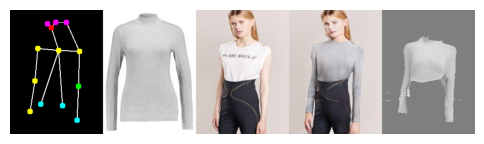

In [19]:
to_key, from_key = '000200_0.jpg', '015272_1.jpg'
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,5,1])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


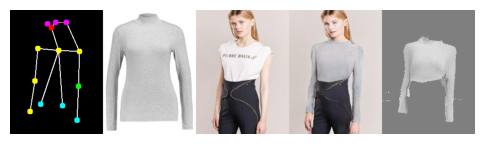

In [16]:
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,1,5])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


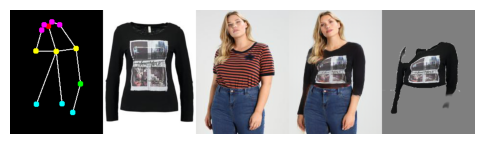

In [20]:
to_key, from_key = '000370_0.jpg', '002397_1.jpg'
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,5,1])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


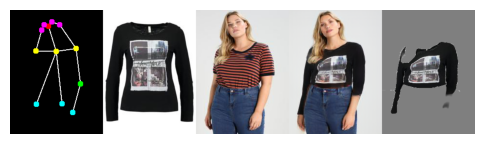

In [21]:
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,1,5])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


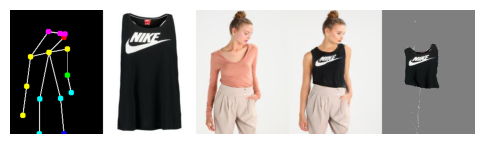

In [22]:
to_key, from_key = '000593_0.jpg', '003998_1.jpg'
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,5,1])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


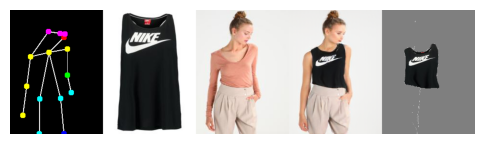

In [23]:
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,1,5])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


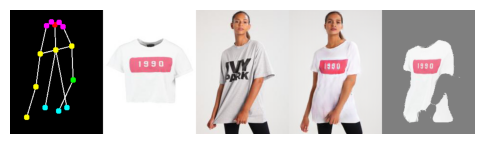

In [28]:
to_key, from_key = '000220_0.jpg', '015308_1.jpg'
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,5,1])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


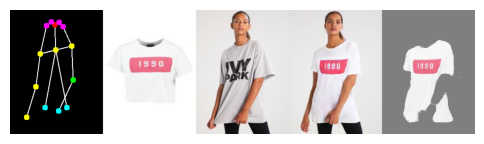

In [29]:
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,1,5])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


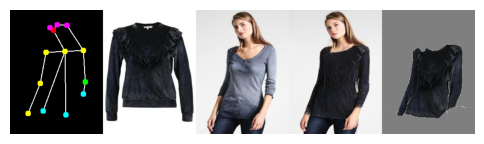

In [26]:
to_key, from_key = '000082_0.jpg', '003291_1.jpg'
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,5,1])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


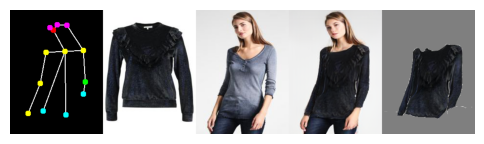

In [27]:
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,1,5])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


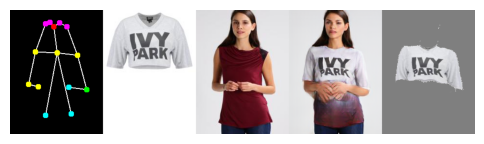

In [34]:
to_key, from_key = '011615_0.jpg', '016328_1.jpg'
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,5,1])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([18, 256, 192])


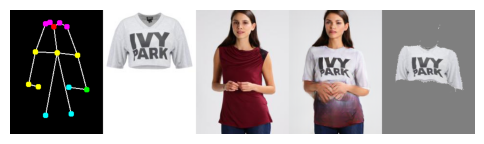

In [35]:
from_img, to_img, gen_img, to_kpt, warp = dress_in_order(model, from_key, to_key, order=[2,1,5])
plot_img(pimg=from_img, gimgs=to_img, gen_img=gen_img, pose=to_kpt, warp=warp)